# Tic Tac Toe
Source: [Reinforcement Learning - Implement TicTacToe](https://towardsdatascience.com/reinforcement-learning-implement-tictactoe-189582bea542)

In [2]:
import math
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils

import tensorflow as tf

In [43]:
class State:
    def __init__(self, p1, p2):
        self.board = np.zeros((3, 3))
        self.winner = (0, False)
        self.p1 = p1
        self.p2 = p2
        self.playerSymbol = 1

    def getHash(self):
        return str(self.board.reshape(9))

    def showBoard(self):
        charMap = {1: 'X', 0: ' ', -1: 'O'}
        for i in range(3):
            print("-"*13)
            for j in range(3):
                print("|", charMap[self.board[i, j]], end=' ')
                if j == 2:
                    print("|")
        print("-"*13)
        print()

    def availablePositions(self):
        positions = []
        for i in range(3):
            for j in range(3):
                if self.board[i, j] == 0:
                    positions.append((i, j))

        return positions

    def updateMove(self, pos):
        if self.board[pos] != 0:
            return False
        
        self.board[pos] = self.playerSymbol
        self.playerSymbol *= -1

        return True

    def checkWinner(self):
        isDone = lambda b: np.max(b) == np.min(b) and np.max(b) != 0

        # Row check
        for i in range(3):
            if isDone(self.board[i]):
                self.winner = (self.board[i, 0], True)
                return self.winner

        # Col check
        for j in range(3):
            if isDone(self.board[:, j]):
                self.winner = (self.board[0, j], True)
                return self.winner

        # Diagonal check
        diagonal1 = np.array([self.board[i, i] for i in range(3)])
        diagonal2 = np.array([self.board[i, -i-1] for i in range(3)])
        if isDone(diagonal1):
            self.winner = (diagonal1[0], True)
        elif isDone(diagonal2):
            self.winner = (diagonal2[0], True)
        elif np.count_nonzero(self.board) == 9:
            self.winner = (0, True)
        else:
            self.winner = (0, False)

        return self.winner

    def giveReward(self, result):
        if result == 1:
            self.p1.feedReward(1)
            self.p2.feedReward(0)
        elif result == -1:
            self.p1.feedReward(0)
            self.p2.feedReward(1)
        else:
            self.p1.feedReward(0.1)
            self.p2.feedReward(0.5)

    def reset(self):
        self.board = np.zeros((3, 3))
        self.winner = (0, False)
        self.playerSymbol = 1

    def play(self, rounds=100, verbose=0):
        for i in range(rounds):
            # if i % 1000 == 0:
            #     print("Rounds {}".format(i))
            while not self.winner[1]:
                # Player 1
                positions = self.availablePositions()
                p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
                # take action and upate board state
                self.updateMove(p1_action)
                board_hash = self.getHash()
                self.p1.addState(board_hash)
                # check board status if it is end

                if i % 100 == 0 and verbose:
                    self.showBoard()

                win = self.checkWinner()
                if win[1]:
                    # ended with p1 either win or draw
                    self.giveReward(win[0])
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                else:
                    # Player 2
                    positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                    self.updateMove(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)

                    win = self.checkWinner()
                    if win[1]:
                        if i % 100 == 0 and verbose:
                            self.showBoard()
                        # ended with p2 either win or draw
                        self.giveReward(win[0])
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break

    # play against human
    def play2(self):
        while not self.winner[1]:
            # Player 1
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
            # take action and upate board state
            self.updateMove(p1_action)
            self.showBoard()
            # check board status if it is end
            win = self.checkWinner()
            if win[1]:
                if win[0] == 1:
                    print(self.p1.name, "wins!")
                else:
                    print("tie!")
                self.reset()
                break

            else:
                # Player 2
                positions = self.availablePositions()
                p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)

                self.updateMove(p2_action)
                self.showBoard()
                win = self.checkWinner()
                if win[1]:
                    if win[0] == -1:
                        print(self.p2.name, "wins!")
                    else:
                        print("tie!")
                    self.reset()
                    break

In [33]:
class Player:
    def __init__(self, name, exp_rate=0.3):
        self.name = name
        self.states = []  # record all positions taken
        self.lr = 0.2
        self.exp_rate = exp_rate
        self.decay_gamma = 0.9
        self.states_value = {}  # state -> value
        self.rewards = []

    def getHash(self, board):
        return str(board.reshape(9))

    def chooseAction(self, positions, board, symbol):
        if np.random.uniform(0, 1) <= self.exp_rate:
            # take random action
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            value_max = float("-inf")
            for p in positions:
                next_board = board.copy()
                next_board[p] = symbol
                next_boardHash = self.getHash(next_board)
                value = 0 if next_boardHash not in self.states_value else self.states_value[next_boardHash]
                if value >= value_max:
                    value_max = value
                    action = p
        
        return action
    
    def addState(self, s):
        self.states.append(s)

    def feedReward(self, reward):
        for st in reversed(self.states):
            if st not in self.states_value:
                self.states_value[st] = 0
            self.states_value[st] += self.lr * (self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]

        self.rewards.append(self.states_value[self.states[0]])

    def reset(self):
        self.states = []

    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.states_value = pickle.load(fr)
        fr.close()

In [42]:
class HumanPlayer:
    def __init__(self, name):
        self.name = name

    def chooseAction(self, positions, board=None, symbol=None):
        while True:
            row = int(input("Input your action row:"))
            col = int(input("Input your action col:"))
            action = (row, col)
            if action in positions:
                return action

    # append a hash state
    def addState(self, state):
        pass

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        pass

    def reset(self):
        pass

In [44]:
# The higher the exp_rate, the less the player learns (1.0 is no learning)
# In any game, player 1 is X, while player 2 is O
p1 = Player('computer', exp_rate=0.1)
p2 = HumanPlayer('human')
p3 = Player('computer2', exp_rate=1.0)
p4 = Player('computer3', exp_rate=0.3)
p5 = Player('computer4', exp_rate=0.3)
game = State(p1, p3)
game2 = State(p4, p5)
game3 = State(p1, p2)

# For computer vs. computer (Q-learning):
game.play(rounds=300, verbose=1)
game2.play(rounds=300)

# For human vs. computer (included in source code) (no learning):
#game3.play2()

-------------
|   |   |   |
-------------
|   |   |   |
-------------
|   |   | X |
-------------

-------------
|   |   |   |
-------------
|   |   | O |
-------------
|   | X | X |
-------------

-------------
|   | O |   |
-------------
|   |   | O |
-------------
| X | X | X |
-------------

-------------
|   |   |   |
-------------
|   |   |   |
-------------
|   |   | X |
-------------

-------------
| X |   |   |
-------------
|   |   |   |
-------------
|   | O | X |
-------------

-------------
| X |   | O |
-------------
|   |   |   |
-------------
| X | O | X |
-------------

-------------
| X |   | O |
-------------
| O |   | X |
-------------
| X | O | X |
-------------

-------------
| X | O | O |
-------------
| O | X | X |
-------------
| X | O | X |
-------------

-------------
|   |   |   |
-------------
|   |   |   |
-------------
|   |   | X |
-------------

-------------
|   |   |   |
-------------
|   |   |   |
-------------
| O | X | X |
-------------

----------

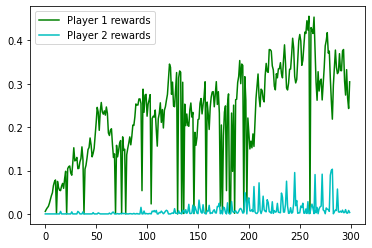

In [45]:
# Only one player learning

n = 300

plt.plot(range(n), p1.rewards[:n], color='g', label='Player 1 rewards')
plt.plot(range(n), p3.rewards[:n], color='c', label='Player 2 rewards')
plt.legend()

plt.show()

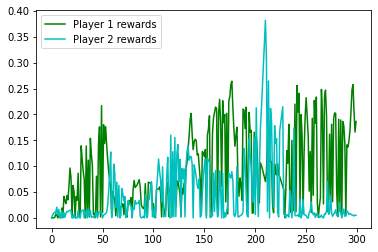

In [46]:
# Both players learning

n = 300

plt.plot(range(n), p4.rewards[:n], color='g', label='Player 1 rewards')
plt.plot(range(n), p5.rewards[:n], color='c', label='Player 2 rewards')
plt.legend()

plt.show()

## Reward and Evaluation
The above graphs are produced using the state value of the initial state for each player and each round. The initial state value represents the total discounted reward of a round, which is why it used as the evaluation metric for a given round. \\

The reward function, borrowed from the source code, is structured such that the winning player receives a reward of 1 while the losing player receives a reward of 0. In the case of a tie, the starting player gets a reward of 0.1, while the other player gets a reward of 0.5, so that the first player is punished more due to the outcome of a Tic-tac-toe game generally depending heavily on the first move of the starting player. \\